In [47]:
import io
import sys
import json
import tqdm
import contextlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from khipu.extended import peaklist_to_khipu_list, export_empCpd_khipu_list
sys.path.insert(0, '..')
from mining import * 
from isf_helper import (extract_ms2_spectrum, 
                        get_comprehensive_stats_per_dataset, 
                        explain_a_dataset_by_mz_deltas, 
                        explain_a_dataset_byMS2)

VERSION = '1_3'
dir_fig_output = f'../fig_for_pub/{VERSION}/tof/'
os.makedirs(dir_fig_output, exist_ok=True)

In [21]:
# Input data 

tof_datasets = [x.rstrip() for x in open('selected_16_tof_datasets.txt').readlines()]
pos_tof_datasets = [x for x in tof_datasets if 'pos' in x]
neg_tof_datasets = [x for x in tof_datasets if 'neg' in x]

# dict_tablefiles = {}
# for line in open('list_input_files.tsv').readlines():
#     a = line.rstrip().split('\t')
#     dict_tablefiles[a[0]] = a[1]

dict_rtwindow = {}
for line in open('elution_parameters_16studies_tof.tsv').readlines()[1:]:
    a = line.rstrip().split('\t')
    dict_rtwindow[a[0]] = float(a[5])

In [22]:
# pos ionization
isotope_search_patterns_pos = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            # (3.9948, '44Ca/40Ca', (0, 0.1)), # 2%
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            ]

isotope_search_patterns_neg = [ (1.003355, '13C/12C', (0, 0.8)),
                            (2.00671, '13C/12C*2', (0, 0.8)),
                            (3.010065, '13C/12C*3', (0, 0.8)),
                            (1.9970, '37Cl/35Cl', (0.1, 0.8)), # 24.24%
                            (1.9958, '32S/34S', (0, 0.1)), # 4%
                            ]

adduct_search_patterns_pos = [  # initial patterns are relative to M+H+
                            (21.98194, 'Na/H'),
                            (41.026549, 'ACN'),     # Acetonitrile
                            (67.987424, 'NaCOOH'),
                            (37.955882, 'K/H'),
                            (32.026215, 'CH3OH')
                            ]
adduct_search_patterns_neg = [  
                            (21.98194, 'Na/H'), 
                            (67.987424, 'NaCOOH'),
                            (82.0030, 'NaCH2COOH'),
                            # (1.99566, 'F <-> OH'), 
                            (41.026549, 'ACN'),
                            (37.955882, 'K/H'),
                            ]
extended_adducts = [  # excluding neutral loss here; include as a step after khipu
                            (1.0078, 'H'),
                            (17.02655, 'NH3'),
                            (18.0106, 'H2O'),      # easy to confuse with bio reactions
                            (18.033823, 'NH4'),
                            (27.01089904, 'HCN'),
                            (27.99492, 'CO'),
                            (32.026215, 'CH3OH'),
                            (35.9767, 'HCl'),
                            (37.94694, 'Ca/H2'),
                            (43.96389, 'Na2/H2'),
                            (46.00548, 'CO2H2'),
                            (67.987424, 'NaCOOH'),
                            (83.961361, 'KCOOH'),
                            (97.96737927, 'H2SO4'),
                            (97.97689507, 'H3PO4'),
]

pos_candidate_fragments = '''18.01	113	18.010565	water	{'H': 2, 'O': 1}
14.015	83	14.015649	addition of acetic acid and loss of CO2.   Reaction: (+C2H2O2) and (-CO2)	{'C': 1, 'H': 2}
2.015	80	2.014552	2H	{'H': 2}
28.0305	59	28.0313	± C2H4, natural alkane chains such as fatty acids	{'C': 2, 'H': 4}
46.0055	54	46.00548	± CO+H2O (carboxylic acid)	{'C': 1, 'O': 2, 'H': 2}
17.0265	53	17.0265	addition of ammonia. Reaction: (+NH3)	{'N': 1, 'H': 3}
11.9995	45	12.0	methylation and reduction	{'C': 1}
44.0255	41	44.0262	hydroxyethylation	{'C': 2, 'H': 4, 'O': 1}
26.015	41	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	{'C': 2, 'H': 2}
15.995	40	15.99492	± O, e.g. oxidation/reduction	{'O': 1}
16.031	39	16.0313	Methylation + reduction	{'C': 1, 'H': 4}
32.026	37	32.026215	MeOH	{'C': 1, 'H': 4, 'O': 1}
39.993	37	39.9925	extra OH sodium adduct	{'H': 1, 'O': 1}
27.9945	37	27.9949	addition of CO. Reaction: (+CO)	{'C': 1, 'O': 1}
23.999	36	24.0	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
42.0465	35	42.04695	± C3H6, propylation	{'C': 3, 'H': 6}
9.984	32	9.98435	addition of CO and loss of water. Reaction: (+CO) and (-H2O)	{'C': 1, 'H': -2}
30.0105	31	30.010564	addition of acetic acid and loss of CO. Reaction: (+C2H2O2) and (-CO)	{'C': 1, 'H': 2, 'O': 1}
56.0625	30	56.0626	± C4H8, butylation	{'C': 4, 'H': 8}
13.979	30	13.979264	nitrification and loss of oxygen. Reaction: (NH2 -> NO2) and (-O)	{'H': -2, 'O': 1}
35.037	21	35.037114	addition of water and addition of ammonia. Reaction: (+H2O) and (+NH3)	{'H': 5, 'N': 1, 'O': 1}
'''
pos_candidate_fragments = [
    (float(x.split()[0]), x) for x in pos_candidate_fragments.splitlines()
]
pos_isf_candidate_fragments = [x[0] for x in pos_candidate_fragments]

In [23]:
def assign_intensity_quartile(list_features):
    '''
    example feature : {'id_number': 'F101',
                'id': 'F101',
                'mz': 113.8853,
                'rtime': 261.81,
                'apex': 261.81,
                'left_base': 261.02,
                'right_base': 263.65,
                'parent_masstrack_id': '1034',
                'peak_area': '433995',
                'cSelectivity': '0.75',
                'goodness_fitting': '0.98',
                'snr': '3',
                'detection_counts': '39',
                'representative_intensity': '433995'}
    returns dict {fid: quartile, ...}
    '''
    for f in list_features:
        f['peak_area'] = float(f['peak_area'])
    d = {}
    intensities = np.array([f['peak_area'] for f in list_features])
    x1, x2, x3 = np.quantile(intensities, 0.75
                        ), np.quantile(intensities, 0.5
                         ), np.quantile(intensities, 0.25)
    
    for f in list_features:
        if f['peak_area'] > x1:
            d[f['id']] = 1  # 1st quartile
        elif x1 >= f['peak_area'] > x2:
            d[f['id']] = 2
        elif x2 >= f['peak_area'] > x3:
            d[f['id']] = 3
        else:
            d[f['id']] = 4
    return d

In [24]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 5 minutes



# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 50 minutes

tally_pos = []
quartile_matches_pos = {}
for study in tqdm.tqdm(pos_tof_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'pos'
        _n, list_features = read_features_from_asari_table(
            open(f'../input_data_tof/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_pos, 
                                adduct_search_patterns=adduct_search_patterns_pos,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=25,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )
    
        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
        remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, pos_isf_candidate_fragments, 
            rt_stdev=dict_rtwindow[study]
            )

        dict_intensity_quartile = assign_intensity_quartile(list_features)
        preannotated_feature_ids = set(list(fids_in_khipus) + explained_feature_ids)
        quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]

        cur_tally = {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                'quartile_matches': quartile_matches,
            }
        tally_pos.append(cur_tally)
        
        M0_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] == 'M0']
        isotope_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] != 'M0']
        fragment_ids = explained_feature_ids
        singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids]
        
        quartile_matches_pos[study] = {
            'M0': [dict_intensity_quartile[x] for x in M0_ids],
            'isotope': [dict_intensity_quartile[x] for x in isotope_ids],
            'fragment': [dict_intensity_quartile[x] for x in fragment_ids],
            'singletons': [dict_intensity_quartile[x] for x in singleton_ids],
        }
        round_id = '01292025_1'
        os.makedirs(f'output_tof/{round_id}/pos/{study}', exist_ok=True)
        json.dump(list_khipus, open(f'output_tof/{round_id}/pos/{study}/ecpds.json', 'w'))
        json.dump(cur_tally, open(f'output_tof/{round_id}/pos/{study}/tally.json', 'w'))
        json.dump(quartile_matches_pos[study], open(f'output_tof/{round_id}/pos/{study}/quartile_matches.json', 'w'))

100%|██████████| 10/10 [12:38<00:00, 75.84s/it]


In [25]:
test0 = tally_pos[0]['quartile_matches']
tally_pos[0]['num_features'], [
    len([x for x in test0 if x ==1]), len([x for x in test0 if x ==2]), 
    len([x for x in test0 if x ==3]), len([x for x in test0 if x ==4]),
]

(4173, [595, 349, 269, 236])

In [26]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 
# fig3a
preannotated_features = [len(x['quartile_matches']) for x in tally_pos]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_pos]

#fig3b
quartile_percs_pos_all_preannotated = [[], [], [], []]
quartile_percs_pos = {'M0': [[], [], [], []], 
                      'isotope': [[], [], [], []], 
                      'fragment': [[], [], [], []], 
                      'singletons': [[], [], [], []], }
for x in tally_pos:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for type, q in quartile_matches_pos[x['study']].items():
        for ii in range(4):
            quartile_percs_pos[type][ii].append(100 * len([y for y in q if y==ii+1]) / quartile_size)
            # Use all preannotated features for violin plot
            quartile_percs_pos_all_preannotated[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)

median_perc_pos = {}
for type, qpp in quartile_percs_pos.items():
    median_perc_pos[type] = [np.mean(qpp[ii]) for ii in range(4)]
median_perc_pos

{'M0': [35.69992649652395,
  20.021872297447622,
  14.869452264764789,
  11.829968743796902],
 'isotope': [23.248522294687294,
  15.300526634822017,
  12.668581519494499,
  10.742357548673834],
 'fragment': [0.7710422949161637,
  0.5340222402918695,
  0.44448419255691024,
  0.356297449244235],
 'singletons': [40.27936762903888,
  64.13428282883268,
  72.01413399426585,
  77.0851615706425]}

11029.0 4501.5


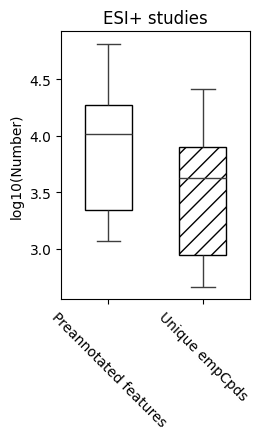

In [ ]:
# Fig 3a. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
}
from matplotlib.ticker import FormatStrFormatter

print(np.median(preannotated_features), np.median(unique_empCpds))

fig, ax = plt.subplots(1, 1, figsize=(2.7, 4.5))
boxplot = sns.boxplot(data=_d, width=0.5)
for i, patch in enumerate(boxplot.patches):
    hatch = "" if i % 2 == 0 else "//"  # Different hatches for alternating boxes
    patch.set_hatch(hatch)
    patch.set_edgecolor('black')  # Set border color
    patch.set_facecolor('white')  # Remove fill color

ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Number)")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Format y-axis with 2 decimal places
ax.set_title("ESI+ studies")
plt.tight_layout()
plt.savefig(f"{dir_fig_output}/Fig3a_preannotation_pos.pdf")

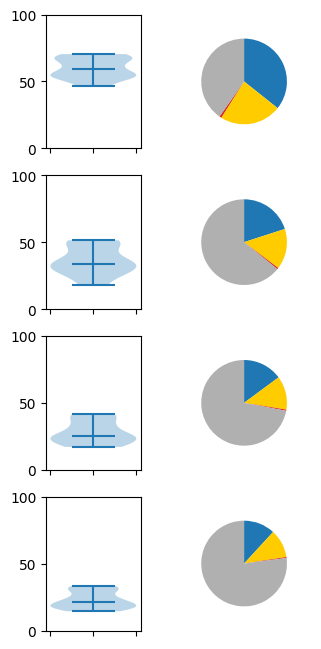

In [ ]:
# Fig. 3b. distribution of perc; pie chart for median pec

piedata = [(median_perc_pos['M0'][i], median_perc_pos['isotope'][i], 
            median_perc_pos['fragment'][i], median_perc_pos['singletons'][i]) for i in range(4)]

colors = ['#1f77b4', '#ffcc00', '#d62728', '#b0b0b0']  # Blue, Yellow, Red, Grey

fig, axs = plt.subplots(4, 2, figsize=(5, 8), gridspec_kw={'wspace': 0.05}) 


for ii in range(4):
    parts = axs[ii, 0].violinplot(
        quartile_percs_pos_all_preannotated[ii],
        showmedians=True,
        showextrema=True
    )
    axs[ii, 0].set_yticks([0, 50, 100])
    axs[ii, 0].tick_params(axis='x', which='both', bottom=True, labelbottom=False)  # Hide tick labels but keep ticks
    
    # Adjust the width of the violin plot (axs[ii, 0])
    pos = axs[ii, 0].get_position()  # Get current position of the violin plot
    axs[ii, 0].set_position([pos.x0 + 0.05, pos.y0, pos.width * 0.5, pos.height])  # Make it 50% narrower


    axs[ii, 1].pie(
        piedata[ii], 
        colors=colors, 
        radius=0.8, 
        startangle=90, 
        counterclock=False,
        # autopct='%1.1f%%'
        )
    # axs[ii].set_title(f"{(ii)*25}% - {(ii + 1)*25}%") 
    
    pos_pie = axs[ii, 1].get_position()  # Get current position of the pie chart
    axs[ii, 1].set_position([pos_pie.x0 - 0.14, pos_pie.y0, pos_pie.width, pos_pie.height])  
    
plt.tight_layout()
plt.savefig(f"{dir_fig_output}/Fig3b_preannotation_pos_piecharts.pdf")


In [11]:
piedata

[(35.69992649652395,
  23.248522294687294,
  0.7710422949161637,
  40.27936762903888),
 (20.021872297447622,
  15.300526634822017,
  0.5340222402918695,
  64.13428282883268),
 (14.869452264764789,
  12.668581519494499,
  0.44448419255691024,
  72.01413399426585),
 (11.829968743796902, 10.742357548673834, 0.356297449244235, 77.0851615706425)]

## Do neg ion studies

In [12]:
neg_candidate_fragments = '''67.9875	140	67.987424	NaCOOH	"{'C': 1, 'O': 2, 'Na': 1, 'H': 1}"
2.015	70	2.014552	2H	{'H': 2}
135.974	49	135.974848	2X NaCOOH	"{'C': 2, 'O': 4, 'H': 2, 'Na': 2}"
82.002	48	82.003035	methylation and addition of trifluoromethyl. Reaction: (+CH2) and (+CF3-H)	"{'C': 2, 'H': 1, 'F': 3}"
1.011	41	1.007276467	1H	{'H':1 }
0.996	39	0.996585	addition of Guanine and loss of D-ribose. Reaction: (+C5H3N5) and (-C5H8O4)	"{'H': -5, 'N': 5, 'O': -4}"
43.989	35	43.9898	addition of CO2. Reaction: (+CO2)	"{'C': 1, 'O': 2}"
14.015	32	14.015649	addition of acetic acid and loss of CO2. Reaction: (+C2H2O2) and (-CO2)	"{'C': 1, 'H': 2}"
46.005	31	46.005305	addition of Phosphate and dechlorination. Reaction: (+HPO3) and (-Cl+H)	"{'H': 2, 'O': 3, 'P': 1, 'Cl': -1}"
26.015	29	26.01565	acetylation and loss of oxygen. Reaction: (+C2H2O) and (-O)	"{'C': 2, 'H': 2}"
61.97	29	61.975755	addition of Phosphate and defluorination. Reaction: (+HPO3) and (-F+H)	"{'H': 2, 'O': 3, 'P': 1, 'F': -1}"
129.957	29	129.958482	addition of di-phosphate and denitrification. Reaction: (+H2P2O6) and (NO2 -> NH2)	"{'H': 4, 'O': 4, 'P': 2}"
60.021	29	-60.0211	desmolysis	"{'C': -2, 'H': -4, 'O': -2}"
74.0365	28	74.03678	propionylation	"{'C': 3, 'H': 6, 'O': 2}"
23.9995	27	24	acetylation and loss of water. Reaction: (+C2H2O) and (-H2O)	{'C': 2}
10.029	27	10.028802	addition of CO2 and dechlorination. Reaction: (+CO2) and (-Cl+H)	"{'C': 1, 'H': 1, 'O': 2, 'Cl': -1}"
44.026	26	44.0262	hydroxyethylation	"{'C': 2, 'H': 4, 'O': 1}"
18.0105	26	18.010565	water	"{'H': 2, 'O': 1}"
6.0165	24	6.010565	addition of tiglyl and loss of phenyl. Reaction: (+C5H6O) and (-C6H5+H)	"{'C': -1, 'H': 2, 'O': 1}"
15.994	23	15.9949	oxidation	{'O': 1}
'''
neg_candidate_fragments = [
    (float(x.split()[0]), x) for x in neg_candidate_fragments.splitlines()
]

isf_candidate_fragments_neg = [x[0] for x in neg_candidate_fragments]

In [13]:
# Detailed explanation of features by khipus and frequent deltas
# **Include feature intensity ranks**
# ~ 2 minutes


tally_neg = []
quartile_matches_neg = {}
for study in tqdm.tqdm(neg_tof_datasets):
    with contextlib.redirect_stdout(io.StringIO()):
        ion_mode = 'neg'
        _n, list_features = read_features_from_asari_table(
            open(f'../input_data_tof/{study}/full_feature_table.tsv').read()
            )
        for f in list_features:
            f['representative_intensity'] = f['peak_area']
        list_khipus, all_assigned_fids = peaklist_to_khipu_list(
                                list_features, 
                                isotope_search_patterns=isotope_search_patterns_neg, 
                                adduct_search_patterns=adduct_search_patterns_neg,
                                extended_adducts=extended_adducts, 
                                mz_tolerance_ppm=25,
                                rt_tolerance=dict_rtwindow[study],
                                mode=ion_mode,
                                charges=[1, 2, 3],
                                )

        # convert khipu instances to dicts
        list_khipus = sorted(export_empCpd_khipu_list(list_khipus), 
                            key=lambda x: x['neutral_formula_mass'], reverse=True)
        fids_in_khipus = set([f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra']])
        remaining_features = [f for f in list_features if f['id'] not in fids_in_khipus]
        
        # by isf_candidate_fragments
        explained_khipu_ids, explained_feature_ids, delta_values_used = explain_a_dataset_by_mz_deltas(
            list_khipus, remaining_features, isf_candidate_fragments_neg, 
            rt_stdev=dict_rtwindow[study]
            )

        dict_intensity_quartile = assign_intensity_quartile(list_features)
        preannotated_feature_ids = set(list(fids_in_khipus) + explained_feature_ids)
        quartile_matches = [dict_intensity_quartile[x] for x in preannotated_feature_ids]

        cur_tally = {
                'study': study,
                'num_khipus': len(list_khipus),
                'num_features':  len(list_features),
                'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
                'mzdelta_explained_features': len(set(explained_feature_ids)),
                'quartile_matches': quartile_matches,
            }
        tally_neg.append(cur_tally)
        
        M0_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] == 'M0']
        isotope_ids = [f['id'] for kp in list_khipus for f in kp['MS1_pseudo_Spectra'] if f['isotope'] != 'M0']
        fragment_ids = explained_feature_ids
        singleton_ids = [f['id'] for f in remaining_features if f['id'] not in fragment_ids]
        
        quartile_matches_neg[study] = {
            'M0': [dict_intensity_quartile[x] for x in M0_ids],
            'isotope': [dict_intensity_quartile[x] for x in isotope_ids],
            'fragment': [dict_intensity_quartile[x] for x in fragment_ids],
            'singletons': [dict_intensity_quartile[x] for x in singleton_ids],
        }
        round_id = '01292025_1'
        os.makedirs(f'output_tof/{round_id}/neg/{study}', exist_ok=True)
        json.dump(list_khipus, open(f'output_tof/{round_id}/neg/{study}/ecpds.json', 'w'))
        json.dump(cur_tally, open(f'output_tof/{round_id}/neg/{study}/tally.json', 'w'))
        json.dump(quartile_matches_neg[study], open(f'output_tof/{round_id}/neg/{study}/quartile_matches.json', 'w'))

100%|██████████| 6/6 [03:50<00:00, 38.40s/it] 


In [14]:
# Get numbers of features explained by pre-annotation (= len(quartile_matches)), 
# and unique empCpds (= num_khipus - mzdelta_explained_khipus)
# 
# fig3a
preannotated_features = [len(x['quartile_matches']) for x in tally_neg]
unique_empCpds = [x['num_khipus']-x['mzdelta_explained_khipus'] for x in tally_neg]

#fig3b
quartile_percs_neg_all_preannotated = [[], [], [], []]
quartile_percs_neg = {'M0': [[], [], [], []], 
                      'isotope': [[], [], [], []], 
                      'fragment': [[], [], [], []], 
                      'singletons': [[], [], [], []], }
for x in tally_neg:
    list_q = x['quartile_matches']
    quartile_size = x['num_features']/4
    for type, q in quartile_matches_neg[x['study']].items():
        for ii in range(4):
            quartile_percs_neg[type][ii].append(100 * len([y for y in q if y==ii+1]) / quartile_size)
            # Use all preannotated features for violin plot
            quartile_percs_neg_all_preannotated[ii].append(100 * len([y for y in list_q if y==ii+1]) / quartile_size)


median_perc_neg = {}
for type, qpp in quartile_percs_neg.items():
    median_perc_neg[type] = [np.mean(qpp[ii]) for ii in range(4)]
median_perc_neg

{'M0': [38.48735396308293,
  20.22686243318921,
  14.429001881310556,
  11.760979335553742],
 'isotope': [25.51232961362497,
  17.60851390875215,
  14.752948010480901,
  12.697985378992984],
 'fragment': [0.8563675670856434,
  0.7812801626740115,
  0.4322938266386918,
  0.3338775830530036],
 'singletons': [35.157032739507535,
  61.34707469410181,
  70.39287446763008,
  75.22322443432178]}

8806.5 3449.5


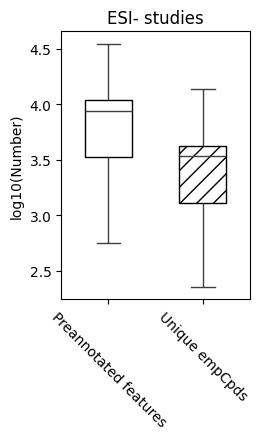

In [ ]:
# Fig 3c. preannotated_features unique_empCpds
_d = {
    'Preannotated features': np.log10(preannotated_features),
    'Unique empCpds': np.log10(unique_empCpds),
}
from matplotlib.ticker import FormatStrFormatter

print(np.median(preannotated_features), np.median(unique_empCpds))

fig, ax = plt.subplots(1, 1, figsize=(2.7, 4.5))
boxplot = sns.boxplot(data=_d, width=0.5)
for i, patch in enumerate(boxplot.patches):
    hatch = "" if i % 2 == 0 else "//"  # Different hatches for alternating boxes
    patch.set_hatch(hatch)
    patch.set_edgecolor('black')  # Set border color
    patch.set_facecolor('white')  # Remove fill color
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10(Number)")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))  # Format y-axis with 2 decimal places

ax.set_title("ESI- studies")
plt.tight_layout()
plt.savefig(f"{dir_fig_output}/Fig3a_preannotation_neg.pdf")

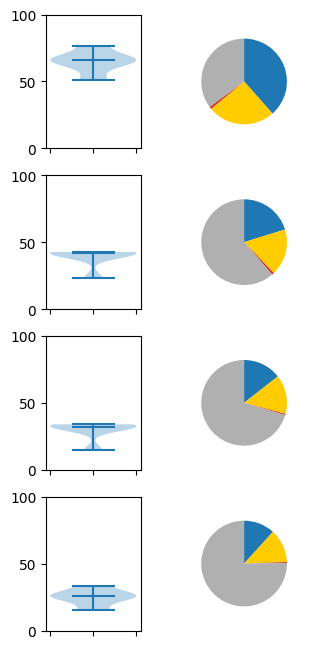

In [ ]:
# Fig. 3b. distribution of perc; pie chart for median pec
piedata = [(median_perc_neg['M0'][i], median_perc_neg['isotope'][i], 
            median_perc_neg['fragment'][i], median_perc_neg['singletons'][i]) for i in range(4)]

colors = ['#1f77b4', '#ffcc00', '#d62728', '#b0b0b0']  # Blue, Yellow, Red, Grey

fig, axs = plt.subplots(4, 2, figsize=(5, 8), gridspec_kw={'wspace': 0.05}) 


for ii in range(4):
    parts = axs[ii, 0].violinplot(
        quartile_percs_neg_all_preannotated[ii],
        showmedians=True,
        showextrema=True
    )
    axs[ii, 0].set_yticks([0, 50, 100])
    axs[ii, 0].tick_params(axis='x', which='both', bottom=True, labelbottom=False)  # Hide tick labels but keep ticks
    
    # Adjust the width of the violin plot (axs[ii, 0])
    pos = axs[ii, 0].get_position()  # Get current position of the violin plot
    axs[ii, 0].set_position([pos.x0 + 0.05, pos.y0, pos.width * 0.5, pos.height])  # Make it 50% narrower


    axs[ii, 1].pie(
        piedata[ii], 
        colors=colors, 
        radius=0.8, 
        startangle=90, 
        counterclock=False,
        # autopct='%1.1f%%'
        )
    # axs[ii].set_title(f"{(ii)*25}% - {(ii + 1)*25}%") 
    
    pos_pie = axs[ii, 1].get_position()  # Get current position of the pie chart
    axs[ii, 1].set_position([pos_pie.x0 - 0.14, pos_pie.y0, pos_pie.width, pos_pie.height])  
    
plt.tight_layout()
plt.savefig(f"{dir_fig_output}/Fig3b_preannotation_neg_piecharts.pdf")

In [17]:
piedata

[(38.48735396308293,
  25.51232961362497,
  0.8563675670856434,
  35.157032739507535),
 (20.22686243318921, 17.60851390875215, 0.7812801626740115, 61.34707469410181),
 (14.429001881310556,
  14.752948010480901,
  0.4322938266386918,
  70.39287446763008),
 (11.760979335553742,
  12.697985378992984,
  0.3338775830530036,
  75.22322443432178)]

# Conclusion

This notebook plots Figure 3. 

Numbers of pre-annotated features by extended khipus in 16 TOF studies.
a,b. Distribution of numbers of pre-annotated features, median value 11,029 and 8,807 for positive and negative ionization datasets, respectively. They correspond to 4,502 and 3,450 unique empirical compounds, respectively.

 c,d. Percentage distribution of pre-annotated features in each intensity quartile in each study, for positive and negative ionization datasets, respectively. The pie charts show mean percentage in each quartile, respectively. 